In [1]:
import pandas as pd

### 데이터 베이스 설정

In [2]:
DB_URL = 'onad.cbjjamtlar2t.ap-northeast-2.rds.amazonaws.com'
DB_USER = 'onad'
DB_PASSWORD = 'rkdghktn12'
DB_DATABASE = 'onad'
DB_CHARSET = 'utf8mb4'
DB_LOGFLAG  = 'False'
DB_PORT = 3306

db_url = "mysql+pymysql://%s:%s@%s:%s/%s?charset=%s" % (
    DB_USER, DB_PASSWORD,
    DB_URL, DB_PORT,
    DB_DATABASE, DB_CHARSET
)

In [3]:
def data_from_sql_twitchchat(streamer, target_date):
    query = """
        select * from twitch_chat where streamer_name = "%s" and broad_date ="%s"
    """% (streamer, target_date)

    return pd.read_sql_query(query, db_url)

### 채팅 데이터 로드

In [4]:
streamer = "rhdgurwns"
target_date = "2018-12-07"
chat_data = data_from_sql_twitchchat(streamer, target_date)

### Exploratory Data Analysis

In [5]:
chat_data.shape

(43246, 6)

In [6]:
chat_data.head()

,chat_id,streamer_name,broad_date,chatterer,chat_time,chat_contents
0,6101494,rhdgurwns,2018-12-07,<ow_easybro>,08:21:23,얍
1,6101495,rhdgurwns,2018-12-07,<loksk3>,08:59:20,반갑고
2,6101496,rhdgurwns,2018-12-07,<qhldlql1>,08:59:49,ㅎㅇ
3,6101497,rhdgurwns,2018-12-07,<qhldlql1>,08:59:52,1빠
4,6101498,rhdgurwns,2018-12-07,<치느님치멘 (wjd760543)>,08:59:58,2ㅃ


In [7]:
print("채팅 로그의 수: %s" % (chat_data.shape[0]))
print("순수 시청자 수: %s" % (len(list(chat_data['chatterer'].unique()))))

채팅 로그의 수: 43246
순수 시청자 수: 3163


In [8]:
print("채팅로그의 시작과 끝 : %s ~ %s " % (sorted(chat_data['chat_time'])[0], sorted(chat_data['chat_time'])[-1]))

채팅로그의 시작과 끝 : 08:21:23 ~ 14:20:40 


### 시간데이터를 DatetimeIndex 로 변경

In [9]:
chat_data['chat_time'] = chat_data['chat_time'].apply(lambda x : target_date + " " + x)

In [10]:
chat_data['time'] = pd.to_datetime(chat_data['chat_time'])
chat_data['time'].head(2)

0   2018-12-07 08:21:23
1   2018-12-07 08:59:20
Name: time, dtype: datetime64[ns]

In [11]:
chat_data_reindex = chat_data.set_index('time')

In [12]:
chat_data_reindex.head(2)

,chat_id,streamer_name,broad_date,chatterer,chat_time,chat_contents
time,,,,,,
2018-12-07 08:21:23,6101494,rhdgurwns,2018-12-07,<ow_easybro>,2018-12-07 08:21:23,얍
2018-12-07 08:59:20,6101495,rhdgurwns,2018-12-07,<loksk3>,2018-12-07 08:59:20,반갑고


## 분석용 데이터셋 제작

#### 1. 필요없는 행 삭제

In [13]:
# 필요없는 행 삭제
del chat_data_reindex['chat_id']
del chat_data_reindex['streamer_name']
del chat_data_reindex['broad_date']
del chat_data_reindex['chat_time']

In [14]:
chat_data_reindex.head(2)

,chatterer,chat_contents
time,,
2018-12-07 08:21:23,<ow_easybro>,얍
2018-12-07 08:59:20,<loksk3>,반갑고


#### 2. 한 문장에서 특정 단어의 수 세어 컬럼으로 생성

In [15]:
chat_data_reindex['cnt_ㅋ'] = chat_data_reindex.chat_contents.apply(lambda x : x.count("ㅋ"))
chat_data_reindex['cnt_ㄵ'] = chat_data_reindex.chat_contents.apply(lambda x : x.count("ㄵ"))
chat_data_reindex['cnt_ㄴㅈ'] = chat_data_reindex.chat_contents.apply(lambda x : x.count("ㄴㅈ"))
chat_data_reindex['cnt_오'] = chat_data_reindex.chat_contents.apply(lambda x : x.count("오"))
chat_data_reindex['cnt_와'] = chat_data_reindex.chat_contents.apply(lambda x : x.count("와"))
chat_data_reindex['cnt_유하'] = chat_data_reindex.chat_contents.apply(lambda x : x.count("유하"))


In [16]:
chat_data_reindex.head(2)

,chatterer,chat_contents,cnt_ㅋ,cnt_ㄵ,cnt_ㄴㅈ,cnt_오,cnt_와,cnt_유하
time,,,,,,,,
2018-12-07 08:21:23,<ow_easybro>,얍,0,0,0,0,0,0
2018-12-07 08:59:20,<loksk3>,반갑고,0,0,0,0,0,0


#### 3. 해당 채팅 수 빈도를 갖는 피봇 데이터 프레임 생성

In [17]:
pivot_df = chat_data_reindex.pivot_table(index=chat_data_reindex.index, aggfunc=len, values='chatterer')
pivot_df.columns = ['cnt_chat']  # 컬럼 이름 할당
pivot_df["cnt_ㅋ"] = chat_data_reindex.pivot_table(index = chat_data_reindex.index, aggfunc=sum, values='cnt_ㅋ')['cnt_ㅋ']
pivot_df["cnt_ㄵ"] = chat_data_reindex.pivot_table(index = chat_data_reindex.index, aggfunc=sum, values='cnt_ㄵ')['cnt_ㄵ'] +\
                    chat_data_reindex.pivot_table(index = chat_data_reindex.index, aggfunc=sum, values='cnt_ㄴㅈ')['cnt_ㄴㅈ']
pivot_df["cnt_오"] = chat_data_reindex.pivot_table(index = chat_data_reindex.index, aggfunc=sum, values='cnt_오')['cnt_오']
pivot_df["cnt_와"] = chat_data_reindex.pivot_table(index = chat_data_reindex.index, aggfunc=sum, values='cnt_와')['cnt_와']
pivot_df["cnt_유하"] = chat_data_reindex.pivot_table(index = chat_data_reindex.index, aggfunc=sum, values='cnt_유하')['cnt_유하']

# 초당 채팅수가 평균 이상인 경우만 보이도록
pivot_df[pivot_df['cnt_chat'] > pivot_df['cnt_chat'].mean()]
print(sorted(pivot_df['cnt_chat'].unique(), reverse=True)[:10])
print(sorted(pivot_df['cnt_ㅋ'].unique(), reverse=True)[:10])

pivot_df.head(2)

[23, 22, 21, 19, 18, 17, 16, 15, 14, 13]
[278, 277, 269, 261, 252, 238, 228, 226, 219, 206]


,cnt_chat,cnt_ㅋ,cnt_ㄵ,cnt_오,cnt_와,cnt_유하
time,,,,,,
2018-12-07 08:21:23,1,0,0,0,0,0
2018-12-07 08:59:20,1,0,0,0,0,0


### 검증데이터를 추가, 검증데이터와 분석데이터간 상관관계를 알아보자

- 검증데이터: yes/no 의 명목형 변수  
- 이외의 다른 열 : 연속형 변수  
명목형 변수와 연속형 변수의 상관관계의 경우 **`Point-biserial correlation`** 을 사용함  
이는 scipy.stats 모듈에 pointbiserialr 메소드로 구현되어 있음

#### 시험해보기 위한 치팅
- 채팅 수가 60% 중위수 이상인 경우 모두 하이라이트영상이 있다고 가정하여 데이터프레임 생성

In [18]:
import numpy as np
anal_df = pivot_df.copy()
percentile = np.percentile(anal_df.cnt_chat.unique(), 70)
anal_df[anal_df['cnt_chat'] > percentile].head(2)

,cnt_chat,cnt_ㅋ,cnt_ㄵ,cnt_오,cnt_와,cnt_유하
time,,,,,,
2018-12-07 13:33:11,16,170,0,0,0,0
2018-12-07 13:33:15,18,127,0,0,0,0


#### 전체 채팅 70% 보다 채팅 수가 높은 경우의 점들을 모두 yes 로

In [19]:
anal_df['validation'] = anal_df['cnt_chat'].apply(lambda x : 1 if x >= percentile else 0)

In [20]:
anal_df['validation'].unique()

array([0, 1], dtype=int64)

#### scipy.stats 불러오기

In [21]:
from scipy import stats
for col in anal_df:
    print("%s 상관 정도 : " % col, stats.pointbiserialr(anal_df[col], anal_df['validation']).correlation)

cnt_chat 상관 정도 :  0.23685589641202878
cnt_ㅋ 상관 정도 :  0.26031797896702774
cnt_ㄵ 상관 정도 :  -0.0018019371392378135
cnt_오 상관 정도 :  0.02267098076202392
cnt_와 상관 정도 :  -0.007229065966109369
cnt_유하 상관 정도 :  -0.00030543758743950224
validation 상관 정도 :  1.0


In [23]:
anal_df.corr()

,cnt_chat,cnt_ㅋ,cnt_ㄵ,cnt_오,cnt_와,cnt_유하,validation
cnt_chat,1.000000,0.533525,0.015900,0.140496,0.131126,0.031330,0.236856
cnt_ㅋ,0.533525,1.000000,-0.004600,0.049282,0.044256,0.050496,0.260318
cnt_ㄵ,0.015900,-0.004600,1.000000,-0.010315,-0.009778,-0.000413,-0.001802
cnt_오,0.140496,0.049282,-0.010315,1.000000,0.021177,-0.001749,0.022671
cnt_와,0.131126,0.044256,-0.009778,0.021177,1.000000,-0.001657,-0.007229
cnt_유하,0.031330,0.050496,-0.000413,-0.001749,-0.001657,1.000000,-0.000305
validation,0.236856,0.260318,-0.001802,0.022671,-0.007229,-0.000305,1.000000


### <center>수집한 검증데이터로 상관관계알아보자</center>
<center>* 공혁준</center>

|영상날짜|영상 시작 시간|종료시간|영상길이|
|--|:---:|:---:|---|
|2018-12-09|13:24:14|18:53:34|5:29:20|
|2018-12-09|16:42:35|16:48:26|0:05:35|
|2018-12-09|17:37:25|17:44:41|0:07:16|
|2018-12-09|16:54:40|17:03:49|0:09:09|
|2018-12-09|17:17:08|17:19:08|0:02:00|

#### 유튜브 영상 시작시간과 끝 시간 딕셔너리 생성

In [24]:
# 유튜브 비디오 시작시간과 끝시간
youtube_video_time = {
    '2018-12-09 16:42:35': '2018-12-09 16:48:26',
    '2018-12-09 17:37:25': '2018-12-09 17:44:41',
    '2018-12-09 16:54:40': '2018-12-09 17:03:49',
    '2018-12-09 17:17:08': '2018-12-09 17:19:08',
}
youtube_video_time1207 = {
    '2018-12-07 14:01:07': '2018-12-07 14:04:53',
    '2018-12-07 13:39:05': '2018-12-07 13:59:53',
    '2018-12-07 12:46:18': '2018-12-07 13:11:40',
#     '2018-12-07 8:59:02': '14:15:13',
}
youtube_video_time1213 = {
    '2018-12-13 19:58:26': '2018-12-13 14:33:24',
}
youtube_video_time1215 = {
    '2018-12-15 14:29:30': '2018-12-15 14:33:24',
    '2018-12-15 14:35:25': '2018-12-15 15:01:20',
}

#### 유튜브 영상 시작, 끝 까지의 모든 초 DATETIME 생성

In [25]:
# 시작시간부터 끝 시간까지의 모든 초의 데이트타임생성
highlight_times = [pd.date_range(start=start, end=end, freq='s') for start, end in youtube_video_time1207.items()]
hl_times = []
for time in highlight_times:
    hl_times.extend(time)


In [26]:
len(hl_times), hl_times[:2]

(2999,
 [Timestamp('2018-12-07 14:01:07', freq='S'),
  Timestamp('2018-12-07 14:01:08', freq='S')])

#### 채팅로그 데이터에 유튜브 영상시간에 해당하면 validation 컬럼 1으로

In [27]:
chat_data_reindex.head(2)

,chatterer,chat_contents,cnt_ㅋ,cnt_ㄵ,cnt_ㄴㅈ,cnt_오,cnt_와,cnt_유하
time,,,,,,,,
2018-12-07 08:21:23,<ow_easybro>,얍,0,0,0,0,0,0
2018-12-07 08:59:20,<loksk3>,반갑고,0,0,0,0,0,0


In [48]:
chat_data_reindex['label'] = chat_data_reindex.index
chat_data_reindex['label'] = chat_data_reindex['label'].apply(lambda x : 1 if x in hl_times else 0)

In [49]:
chat_data_reindex.validation.unique()

array([0, 1], dtype=int64)

#### 빈도수로 피봇된 테이블에 validation 컬럼 추가

In [31]:
anal_df.validation = anal_df.index
anal_df.validation = anal_df.validation.apply(lambda x : 1 if x in hl_times else 0)

In [32]:
anal_df.validation.unique()

array([0, 1], dtype=int64)

In [33]:
anal_df.corr()

,cnt_chat,cnt_ㅋ,cnt_ㄵ,cnt_오,cnt_와,cnt_유하,validation
cnt_chat,1.000000,0.533525,0.015900,0.140496,0.131126,0.031330,0.270852
cnt_ㅋ,0.533525,1.000000,-0.004600,0.049282,0.044256,0.050496,0.093870
cnt_ㄵ,0.015900,-0.004600,1.000000,-0.010315,-0.009778,-0.000413,-0.019279
cnt_오,0.140496,0.049282,-0.010315,1.000000,0.021177,-0.001749,0.042912
cnt_와,0.131126,0.044256,-0.009778,0.021177,1.000000,-0.001657,0.032068
cnt_유하,0.031330,0.050496,-0.000413,-0.001749,-0.001657,1.000000,0.017025
validation,0.270852,0.093870,-0.019279,0.042912,0.032068,0.017025,1.000000


In [47]:
anal_df[anal_df['cnt_chat'] > 20]
# 분석용 데이터 셋

# validation :
# 하이라이트 영상으로 실제 올라간 경우 : 1,
# 하이라이트 영상으로 올라가지 않은 경우 :0

# 단어를 모두 흥미/ 등등의 카테고리화

,cnt_chat,cnt_ㅋ,cnt_ㄵ,cnt_오,cnt_와,cnt_유하,validation
time,,,,,,,
2018-12-07 13:37:53,21,26,0,0,0,0,0
2018-12-07 13:38:32,22,261,0,1,0,0,0
2018-12-07 13:39:39,22,75,0,0,0,0,1
2018-12-07 14:01:48,22,143,0,0,0,0,1
2018-12-07 14:01:49,23,219,0,1,0,0,1


In [35]:
# 유튜브 영상이 존재하는지 여부를 중심으로 데이터 분할
yes_data = anal_df[anal_df['label'] == 1]
no_data = anal_df[anal_df['label'] == 0]

# 분할된 데이터 인덱스를 시간으로만 변경
# no_data.index = [i.time() for i in no_data.index]
# yes_data.index = [i.time() for i in yes_data.index]

In [36]:
no_data.head()

,cnt_chat,cnt_ㅋ,cnt_ㄵ,cnt_오,cnt_와,cnt_유하,validation
time,,,,,,,
2018-12-07 08:21:23,1,0,0,0,0,0,0
2018-12-07 08:59:20,1,0,0,0,0,0,0
2018-12-07 08:59:49,1,0,0,0,0,0,0
2018-12-07 08:59:52,1,0,0,0,0,0,0
2018-12-07 08:59:58,2,0,0,0,0,0,0


In [37]:
# 등분산 검정
for i in anal_df:
    print("%s_pvalue: " % i, stats.bartlett(yes_data[i], no_data[i]).pvalue)
    if stats.bartlett(yes_data[i], no_data[i]).pvalue < 0.01: print("유의함")

cnt_chat_pvalue:  5.3004579138429735e-161
유의함
cnt_ㅋ_pvalue:  6.901999378529401e-220
유의함
cnt_ㄵ_pvalue:  0.0
유의함
cnt_오_pvalue:  5.688701647535172e-101
유의함
cnt_와_pvalue:  2.8016889690615178e-86
유의함
cnt_유하_pvalue:  0.0
유의함
validation_pvalue:  nan


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1852: RuntimeWarning: divide by zero encountered in log
  numer = (Ntot*1.0 - k) * log(spsq) - np.sum((Ni - 1.0)*log(ssq), axis=0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1852: RuntimeWarning: invalid value encountered in double_scalars
  numer = (Ntot*1.0 - k) * log(spsq) - np.sum((Ni - 1.0)*log(ssq), axis=0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [38]:
# 정규성 검정
# Kolmogorov-Smirnov 검정은 사실 정규 분포에 국한되지 않고 두 표본이 같은 분포를 따르는지 확인할 수 있는 방법이다. 
# scipy.stats.ks_2samp()
for i in anal_df:
    print("%s_pvalue: "% i, stats.ks_2samp(yes_data[i], no_data[i]))
    if stats.ks_2samp(yes_data[i], no_data[i]).pvalue < 0.01: print("유의함")

cnt_chat_pvalue:  Ks_2sampResult(statistic=0.2796365843160465, pvalue=3.105830325142427e-153)
유의함
cnt_ㅋ_pvalue:  Ks_2sampResult(statistic=0.08496909247255158, pvalue=1.5576729763222488e-14)
유의함
cnt_ㄵ_pvalue:  Ks_2sampResult(statistic=0.002671031318989603, pvalue=0.9999999999999999)
cnt_오_pvalue:  Ks_2sampResult(statistic=0.020711544197548393, pvalue=0.2893528243965644)
cnt_와_pvalue:  Ks_2sampResult(statistic=0.013584726945496062, pvalue=0.8007026380156653)
cnt_유하_pvalue:  Ks_2sampResult(statistic=0.00035984166966529507, pvalue=1.0000000000000018)
validation_pvalue:  Ks_2sampResult(statistic=1.0, pvalue=0.0)
유의함


In [39]:
# ttest
for i in anal_df:
    print(stats.ttest_ind(yes_data[i], no_data[i]))
    if stats.ttest_ind(yes_data[i], no_data[i]).pvalue < 0.01: print("유의함")    

Ttest_indResult(statistic=33.62216620868954, pvalue=1.4128032246889417e-238)
유의함
Ttest_indResult(statistic=11.26666918292028, pvalue=2.548598705678316e-29)
유의함
Ttest_indResult(statistic=-2.3041119415644498, pvalue=0.021230645124097336)
Ttest_indResult(statistic=5.132458944022697, pvalue=2.897354200601421e-07)
유의함
Ttest_indResult(statistic=3.833918324156586, pvalue=0.00012665941514396252)
유의함
Ttest_indResult(statistic=2.0346520398146053, pvalue=0.04190433406551452)
Ttest_indResult(statistic=inf, pvalue=0.0)
유의함


In [40]:
yes_data.describe()
# 실제 유튜브 영상으로 올라간 시간대의 기술통계

,cnt_chat,cnt_ㅋ,cnt_ㄵ,cnt_오,cnt_와,cnt_유하,validation
count,2779.000000,2779.000000,2779.000000,2779.000000,2779.000000,2779.000000,2779.0
mean,4.348687,8.806045,0.000720,0.093919,0.066931,0.000360,1.0
std,3.045558,21.092467,0.026822,0.397294,0.313800,0.018969,0.0
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,6.000000,9.000000,0.000000,0.000000,0.000000,0.000000,1.0
max,23.000000,278.000000,1.000000,6.000000,5.000000,1.000000,1.0


In [41]:
no_data.describe()
# 하이라이트 영상으로 올라가지 않은 시간대의 기술통계

,cnt_chat,cnt_ㅋ,cnt_ㄵ,cnt_오,cnt_와,cnt_유하,validation
count,11502.000000,11502.000000,11502.000000,11502.000000,11502.000000,11502.0,11502.0
mean,2.709181,5.146062,0.004173,0.059555,0.046340,0.0,0.0
std,2.089765,13.630308,0.077904,0.294015,0.237422,0.0,0.0
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
50%,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
75%,4.000000,4.000000,0.000000,0.000000,0.000000,0.0,0.0
max,22.000000,277.000000,3.000000,10.000000,5.000000,0.0,0.0


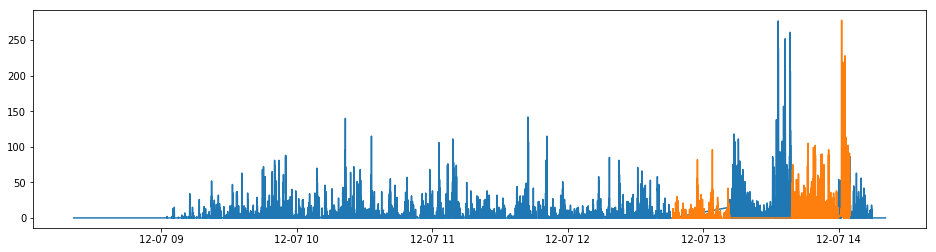

In [50]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16,4))
plt.plot(no_data.index, no_data['cnt_ㅋ'])
plt.plot(yes_data.index, yes_data['cnt_ㅋ'])
plt.show()
# 유튜브 편집자 개인에 대한 학습 / 개인의 편집 스타일(평균 영상시간/ 영상의 채팅빈도수/ 'ㅋ' 수 등등)을 학습하여
# 편집점을 추천해주는 방식

In [53]:
anal_df[anal_df['cnt_ㅋ'] > 250]

,cnt_chat,cnt_ㅋ,cnt_ㄵ,cnt_오,cnt_와,cnt_유하,validation
time,,,,,,,
2018-12-07 13:33:13,13,277,0,0,0,0,0
2018-12-07 13:36:19,14,252,0,0,0,0,0
2018-12-07 13:38:32,22,261,0,1,0,0,0
2018-12-07 14:01:15,13,269,0,0,0,0,1
2018-12-07 14:01:17,15,278,0,0,0,0,1


In [70]:
chat_data_reindex[chat_data_reindex.index=="2018-12-07 14:01:15"].head(2)

,chatterer,chat_contents,cnt_ㅋ,cnt_ㄵ,cnt_ㄴㅈ,cnt_오,cnt_와,cnt_유하,validation,label
time,,,,,,,,,,
2018-12-07 14:01:15,<베리멜론 (ccg5821)>,공혁준 월드컵ㅋㅋㅋㅋㅋㅋㅋㅋㅋ,9,0,0,0,0,0,1,1
2018-12-07 14:01:15,<아크닉스 (qudcks52091)>,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,14,0,0,0,0,0,1,1


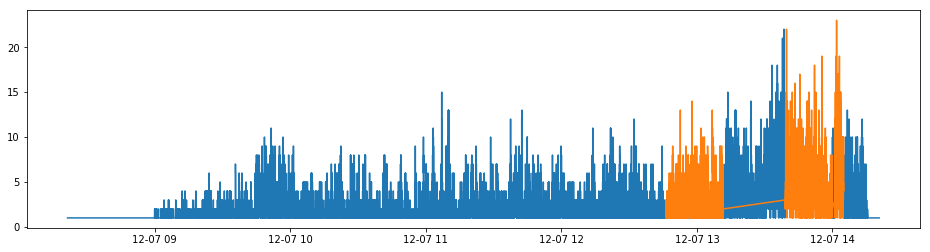

In [45]:
plt.figure(figsize=(16,4))
plt.plot(no_data.index, no_data['cnt_chat'])
plt.plot(yes_data.index, yes_data['cnt_chat'])
plt.show()


In [72]:
anal_df[anal_df['cnt_chat'] > 20]

,cnt_chat,cnt_ㅋ,cnt_ㄵ,cnt_오,cnt_와,cnt_유하,validation
time,,,,,,,
2018-12-07 13:37:53,21,26,0,0,0,0,0
2018-12-07 13:38:32,22,261,0,1,0,0,0
2018-12-07 13:39:39,22,75,0,0,0,0,1
2018-12-07 14:01:48,22,143,0,0,0,0,1
2018-12-07 14:01:49,23,219,0,1,0,0,1
